# Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ for DESIJ0136-0008

**Author(s)**: Sulyman Hossain, S M Rafee Adnan, Anowar Shajib

## Import Libraries

In [1]:
!pip install pandas
!pip install yaml
!pip install astropy
!pip install photutils

ERROR: Could not find a version that satisfies the requirement yaml (from versions: none)
ERROR: No matching distribution found for yaml
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.7/738.7 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.5 MB/s eta 0:00:00


In [2]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

## Load Data

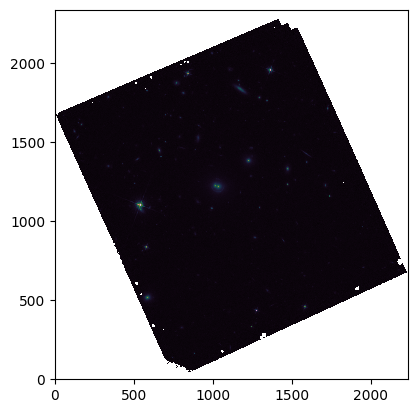

In [3]:
data, header = fits.getdata(
    "/kaggle/input/fits-file/DESIJ0136-0008_F140W_drz_sci.fits", header=True
)
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

/tmp/ipykernel_17/3998831433.py:12: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background),
/tmp/ipykernel_17/3998831433.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


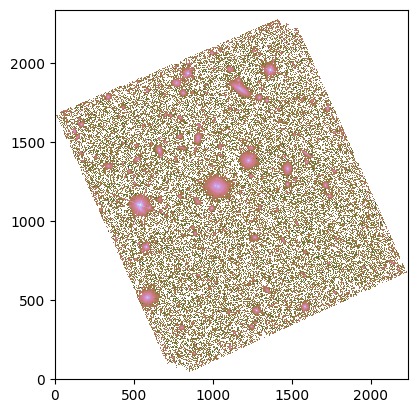

In [4]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture Photometry and Plotting

/tmp/ipykernel_17/3107831899.py:25: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_17/3107831899.py:25: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


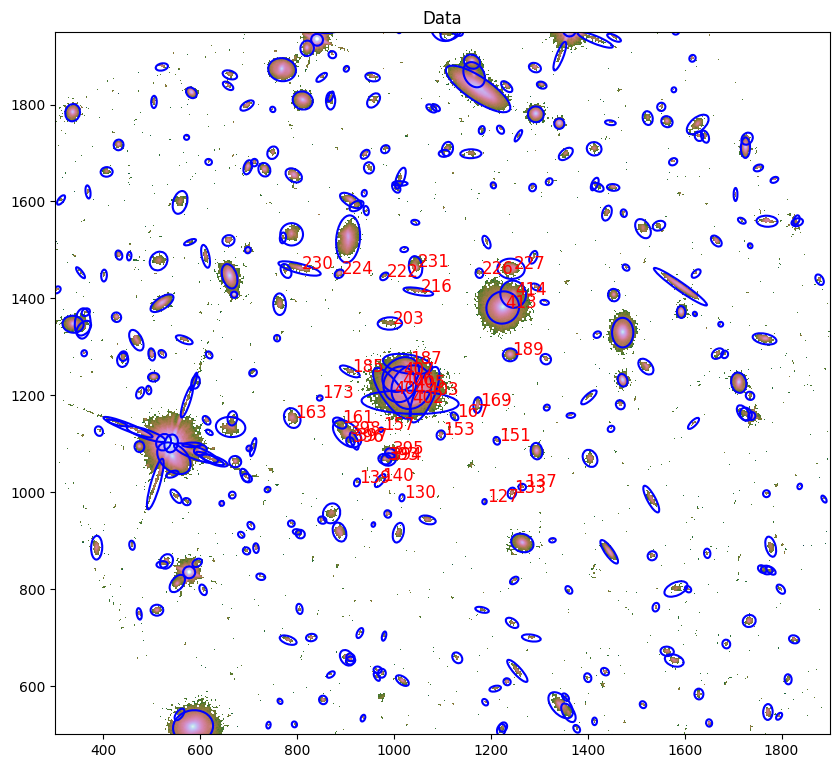

In [5]:
# Background subtraction
bkg_subtracted_data = data - bkg.background

# Source detection and segmentation
threshold = 5 * bkg.background_rms
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

# Source catalog creation
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)

# Plotting
norm = simple_norm(data, "sqrt")
fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

# Plot Kron apertures and label nearby sources
cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)
for i in range(len(cat)):
    if (
        np.abs(cat.xcentroid[i] - cat.xcentroid[405]) < 250
        and np.abs(cat.ycentroid[i] - cat.ycentroid[405]) < 250
    ):
        ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

# Set axis limits
zoom = 300
set_x_lim1, set_x_lim2 = 600-zoom, 1600+zoom
set_y_lim1, set_y_lim2 = 800-zoom, 1650+zoom

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# Hide text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

# Show the plot
plt.show()

## Identify the central deflector's ID

/tmp/ipykernel_17/708862328.py:12: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background),
/tmp/ipykernel_17/708862328.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


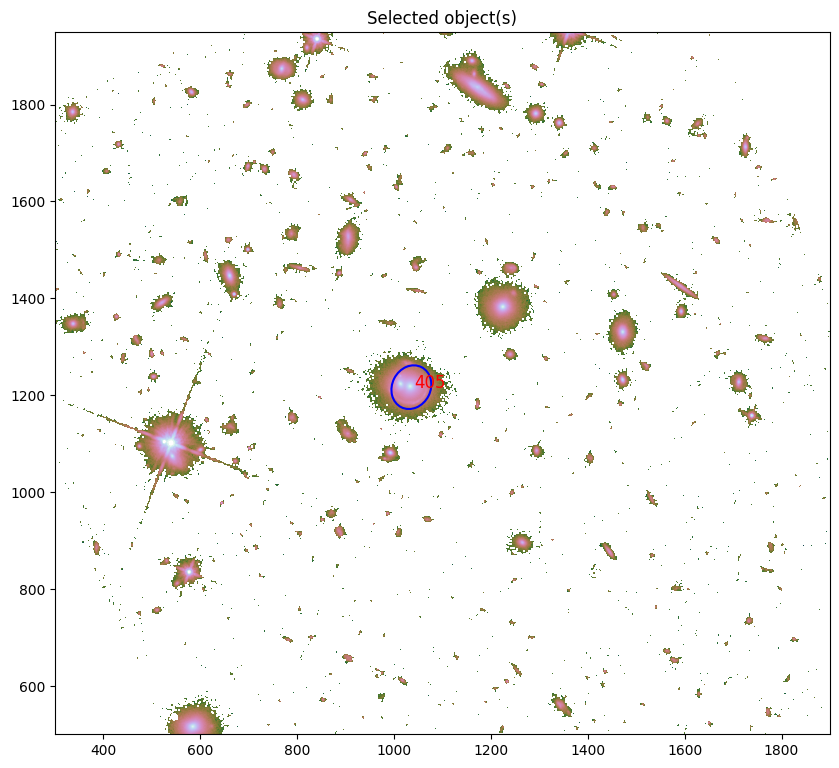

In [6]:
# Defining a function for labeling only selected objects


def label_selected_objects(selected_ids):
    # Background subtraction
    data - bkg.background

    # Plotting
    simple_norm(data, "sqrt")
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
    ax1.imshow(
        np.log10(data - bkg.background),
        origin="lower",
        cmap="cubehelix",
        vmin=-4,
        vmax=2,
    )
    ax1.set_title("Selected object(s)")

    # Plot Kron apertures and label selected objects
    for obj_id in selected_ids:
        labels = [obj_id + 1]
        cat_subset = cat.get_labels(labels)
        cat_subset.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

        ax1.text(
            cat.xcentroid[obj_id] + 5,
            cat.ycentroid[obj_id],
            f"{obj_id}",
            c="r",
            fontsize=12
            # transform=ax1.transAxes
        )

    # Set axis limits
    ax1.set_xlim(set_x_lim1, set_x_lim2)
    ax1.set_ylim(set_y_lim1, set_y_lim2)

    # Hide text outside of the axes
    ax1.set_clip_on(True)
    ax1.set_clip_box(ax1.bbox)

    # Show the plot
    plt.show()


# Guessing the lens galaxy
id_central = 405

# Calling the function label id_central
label_selected_objects([id_central])

In [7]:
# optional format
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating A List of Neighboring Galaxies

In [8]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 25 / 0.08:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print(
    "Number of all close galaxies within 25 arcsecond radius:", len(close_galaxies_all)
)

Number of all close galaxies within 25 arcsecond radius: 47


In [9]:
# Close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 60 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of close galaxies excluding dim sources within 60 arcsecond radius:",
    len(close_galaxies_1),
)

Number of close galaxies excluding dim sources within 60 arcsecond radius: 64


## Pixels to Megaparsec unit

In [10]:
def distance_parsec(pixel_distance, z):
    """Convert distance from unit of pixels into parsec unit.

    :param pixel_distance: distance in unit of pixels

    :param z: photometric redshift

    :return: distance in parsec unit

    """

    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert the pixel scale from degrees to radians
    pix_scale_radian = pix_scale_deg * np.pi / 180

    # Angles in radians
    angles_radian = pixel_distance * pix_scale_radian

    # Define cosmological parameters
    H0 = 70  # Hubble constant in km/s/Mpc
    Om0 = 0.3  # Matter density parameter
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

    # Compute the angular diameter distance
    angular_diameter_distance = cosmo.angular_diameter_distance(z)

    # Calculate the physical distance
    physical_distances_mpc = angular_diameter_distance * angles_radian

    return physical_distances_mpc

## Identify the unwanted objects

/tmp/ipykernel_17/708862328.py:12: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background),
/tmp/ipykernel_17/708862328.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


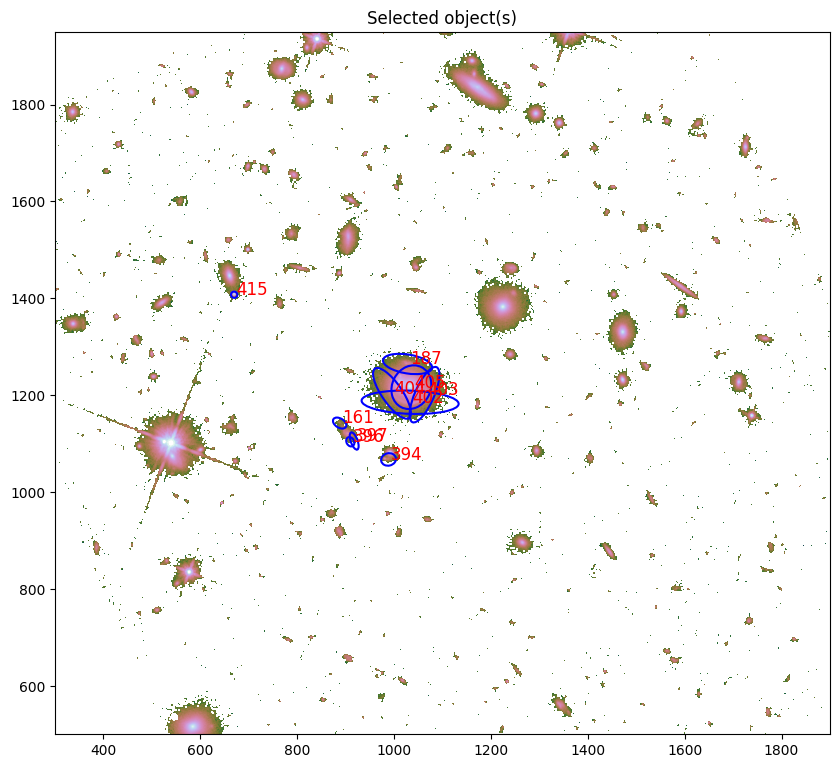

In [11]:
selected_object_ids = [405, 187, 402, 403, 404, 415, 394, 397, 161, 396]
label_selected_objects(selected_object_ids)

## Removing the unwanted objects from the neighboring galaxy list

In [12]:
# All close galaxies

# Lens galaxy: 405
# ARC objects: 187, 402, 403, 404
# Artifacts: 394, 397, 161, 396
remove_list = [
    187,
    402,
    403,
    404,
    405,
    394,
    397,
    161,
    396,
    153, 167, 169, 395, 140, 398, 173, 185, 216, 231, 163, 398, 395
]
df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

# Photometric redshift of the deflector galaxy is 0.34
df_all["Distance(megaparsec)"] = distance_parsec(df_all["Distance(pixels)"], 0.34)
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20.shape)
print(df_all_20)

(20, 4)
     Distance(pixels)  Distance(megaparsec)         Flux  Axis Ratio
406         24.628408              0.009550  3121.558114    0.890247
407         34.112669              0.013228   679.385442    0.762881
157        107.837839              0.041816     6.093080    0.916767
203        138.785453              0.053816    29.003344    0.506904
393        158.329150              0.061394    36.170672    0.773093
151        208.150881              0.080714     9.458718    0.786928
189        214.507306              0.083178   105.977626    0.883842
139        226.482048              0.087822     4.346666    0.701982
130        229.172144              0.088865     3.707763    0.708926
222        235.482693              0.091312     8.259519    0.658725
413        250.311722              0.097062  2938.069417    0.948893
122        266.272624              0.103251    18.048246    0.887262
226        274.090103              0.106282    12.639588    0.812260
119        276.075762     

In [13]:
# Excluding galaxies lower than 1% of the central deflector

# Lens galaxy: 405
# ARC objects: 187, 402, 403, 404
# Probable Stars: 415, 387, 386, 388, 389
remove_list_1 = [
    187,
    402,
    403,
    404,
    405,
    415,
     395, 398, 231, 227, 238, 230, 163, 398, 395, 111, 387, 386, 388, 389, 182, 416, 239, 247, 418, 280, 282, 156, 158, 136, 197, 284, 179, 206, 146, 108, 101, 390, 306, 214, 178
]

df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})
df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

# Photometric redshift of the deflector galaxy is 0.34
df_1["Distance(megaparsec)"] = distance_parsec(df_1["Distance(pixels)"], 0.34)
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratioe"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list_1)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20.shape)
print(df_1_20)

(20, 4)
     Distance(pixels)  Distance(megaparsec)         Flux  Axis Ratioe
406         24.628408              0.009550  3121.558114     0.890247
407         34.112669              0.013228   679.385442     0.762881
189        214.507306              0.083178   105.977626     0.883842
413        250.311722              0.097062  2938.069417     0.948893
414        284.606198              0.110360   182.325473     0.930658
196        450.589198              0.174723  1279.013285     0.719593
385        511.755114              0.198440  1659.575604     0.669628
210        543.244574              0.210651   255.034842     0.439299
148        574.735780              0.222862    60.818991     0.894146
378        597.191524              0.231570  5447.260660     0.978465
311        619.135984              0.240079   423.412780     0.990281
377        630.649761              0.244544    55.830936     0.584895
421        630.947796              0.244659  3093.189294     0.314499
317        6

## Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ and the corresponding radii

## Loading Global Mean

In [14]:
# Read flux data from each YAML file and append to corresponding lists
input_path = "/kaggle/input/global-means-updated/DESIJ0136-0008_means.yml"

try:
    with open(input_path, "r") as f:
        data_mean = yaml.safe_load(f)
except (AttributeError, yaml.YAMLError) as e:
    print(f"Failed to load the file: {e}")

global_mean_flux_10 = data_mean.get("Global_mean_flux_10")
global_mean_flux_20 = data_mean.get("Global_mean_flux_20")
global_mean_flux_selected_10 = data_mean.get("Global_mean_flux_selected_10")
global_mean_flux_selected_20 = data_mean.get("Global_mean_flux_selected_20")
global_mean_flux_dis_10 = data_mean.get("Global_mean_flux_dis_10")
global_mean_flux_dis_20 = data_mean.get("Global_mean_flux_dis_20")
global_mean_flux_dis_selected_10 = data_mean.get("Global_mean_flux_dis_selected_10")
global_mean_flux_dis_selected_20 = data_mean.get("Global_mean_flux_dis_selected_20")

## Method A

In [15]:
# For all sources
R_10_all = df_all_20.iloc[9, df_all_20.columns.get_loc("Distance(megaparsec)")]
R_20_all = df_all_20.iloc[19, df_all_20.columns.get_loc("Distance(megaparsec)")]
Sigma_10_allA = 10 / (np.pi * R_10_all**2)
Sigma_20_allA = 20 / (np.pi * R_20_all**2)

# Excluding dim sources
R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(megaparsec)")]
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(megaparsec)")]
Sigma_10_1A = 10 / (np.pi * R_10_1**2)
Sigma_20_1A = 20 / (np.pi * R_20_1**2)


print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_allA)
print("Sigma 20:", Sigma_20_allA)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1A)
print("Sigma 20:", Sigma_20_1A)


FOR All SOURCES
R 10: 0.09131184405897692
R 20: 0.11036019872036075
Sigma 10: 381.76481561908224
Sigma 20: 522.70321981249

EXCLUDING DIM SOURCES
R 10: 0.23156971177742933
R 20: 0.28127199048810386
Sigma 10: 59.35900562639013
Sigma 20: 80.46873049778189


## Method B

In [16]:
weighted_flux_10_all = np.sum(df_all_20["Flux"][0:10]) / global_mean_flux_10
weighted_flux_20_all = np.sum(df_all_20["Flux"][0:20]) / global_mean_flux_20
Sigma_10_allB = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allB = weighted_flux_20_all / (np.pi * R_20_all**2)


weighted_flux_10_1 = np.sum(df_1_20["Flux"][0:10]) / global_mean_flux_selected_10
weighted_flux_20_1 = np.sum(df_1_20["Flux"][0:20]) / global_mean_flux_selected_20
Sigma_10_1B = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1B = weighted_flux_20_1 / (np.pi * R_20_1**2)


print("")
print("Considering Light Flux")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allB)
print("Sigma 20_updated:", Sigma_20_allB)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1B)
print("Sigma 20_updated:", Sigma_20_1B)


Considering Light Flux
FOR All SOURCES
R 10: 0.09131184405897692
R 20: 0.11036019872036075
Sigma 10_updated: 2150.733596521855
Sigma 20_updated: 2893.693698133874

EXCLUDING DIM SOURCES
R 10: 0.23156971177742933
R 20: 0.28127199048810386
Sigma 10_updated: 436.5448068628626
Sigma 20_updated: 497.6213361180123


## Method C

In [17]:
flux_c_10_all = []
flux_c_20_all = []
flux_c_10_1 = []
flux_c_20_1 = []

# for all sources
for i in range(20):
    flux_all = (
        df_all_20["Flux"][i : i + 1] / df_all_20["Distance(megaparsec)"][i : i + 1]
    )

    if i < 10:
        flux_c_10_all.append(flux_all)
        flux_c_20_all.append(flux_all)

    elif 9 < i < 20:
        flux_c_20_all.append(flux_all)

weighted_flux_10_all = np.sum(flux_c_10_all) / global_mean_flux_dis_10
weighted_flux_20_all = np.sum(flux_c_20_all) / global_mean_flux_dis_20
Sigma_10_allC = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allC = weighted_flux_20_all / (np.pi * R_20_all**2)

# excluding dim sources
for i in range(20):
    flux_1 = df_1_20["Flux"][i : i + 1] / df_1_20["Distance(megaparsec)"][i : i + 1]

    if i < 10:
        flux_c_10_1.append(flux_1)
        flux_c_20_1.append(flux_1)

    elif 9 < i < 20:
        flux_c_20_1.append(flux_1)

weighted_flux_10_1 = np.sum(flux_c_10_1) / global_mean_flux_selected_10
weighted_flux_20_1 = np.sum(flux_c_20_1) / global_mean_flux_selected_20
Sigma_10_1C = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1C = weighted_flux_20_1 / (np.pi * R_20_1**2)


print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allC)
print("Sigma 20_updated:", Sigma_20_allC)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1C)
print("Sigma 20_updated:", Sigma_20_1C)


Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.09131184405897692
R 20: 0.11036019872036075
Sigma 10_updated: 13634.102563671573
Sigma 20_updated: 12148.37376275045

EXCLUDING DIM SOURCES
R 10: 0.23156971177742933
R 20: 0.28127199048810386
Sigma 10_updated: 12547.938713355832
Sigma 20_updated: 10803.720196593766


## Method D

## Visualization

In [18]:
# Initialize flux variables
flux_d_10_all = []
flux_d_20_all = []
flux_d_10_1 = []
flux_d_20_1 = []

# Define a short radius
pixel_distance = 125  # for 10 arcseconds

# Mean Photometric redshift of all the deflectors is 0.581
s = distance_parsec(pixel_distance, 0.581).value

# Process both dataframes
for i in range(20):
    distance_all = df_all_20["Distance(megaparsec)"].iloc[i]
    flux_all = df_all_20["Flux"].iloc[i]
    distance_1 = df_1_20["Distance(megaparsec)"].iloc[i]
    flux_1 = df_1_20["Flux"].iloc[i]

    # Processing for df_all_20
    if i < 10:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all

        flux_d_10_all.append(flux_contrib_all)
        flux_d_20_all.append(flux_contrib_all)

    elif 9 < i < 20:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all

        flux_d_20_all.append(flux_contrib_all)

    # Processing for df_1_20
    if i < 10:
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1

        flux_d_10_1.append(flux_contrib_1)
        flux_d_20_1.append(flux_contrib_1)

    elif 9 < i < 20:
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1

        flux_d_20_1.append(flux_contrib_1)

weighted_flux_10_all = np.sum(flux_d_10_all) / global_mean_flux_dis_10
weighted_flux_20_all = np.sum(flux_d_20_all) / global_mean_flux_dis_20
Sigma_10_allD = weighted_flux_10_all / (np.pi * R_10_all**2)
Sigma_20_allD = weighted_flux_20_all / (np.pi * R_20_all**2)

weighted_flux_10_1 = np.sum(flux_d_10_1) / global_mean_flux_selected_10
weighted_flux_20_1 = np.sum(flux_d_20_1) / global_mean_flux_selected_20
Sigma_10_1D = weighted_flux_10_1 / (np.pi * R_10_1**2)
Sigma_20_1D = weighted_flux_20_1 / (np.pi * R_20_1**2)

# Print results
print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allD)
print("Sigma 20_updated:", Sigma_20_allD)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1D)
print("Sigma 20_updated:", Sigma_20_1D)


Considering Light Flux And Distance
FOR All SOURCES
R 10: 0.09131184405897692
R 20: 0.11036019872036075
Sigma 10_updated: 2160.123292969178
Sigma 20_updated: 2744.410748677198

EXCLUDING DIM SOURCES
R 10: 0.23156971177742933
R 20: 0.28127199048810386
Sigma 10_updated: 3652.615935684964
Sigma 20_updated: 3538.9043996170394


/tmp/ipykernel_17/4146286428.py:17: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_17/4146286428.py:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_17/4146286428.py:20: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_17/4146286428.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_17/4146286428.py:23: RuntimeWarning: divide by zero encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_17/4146286428.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower",

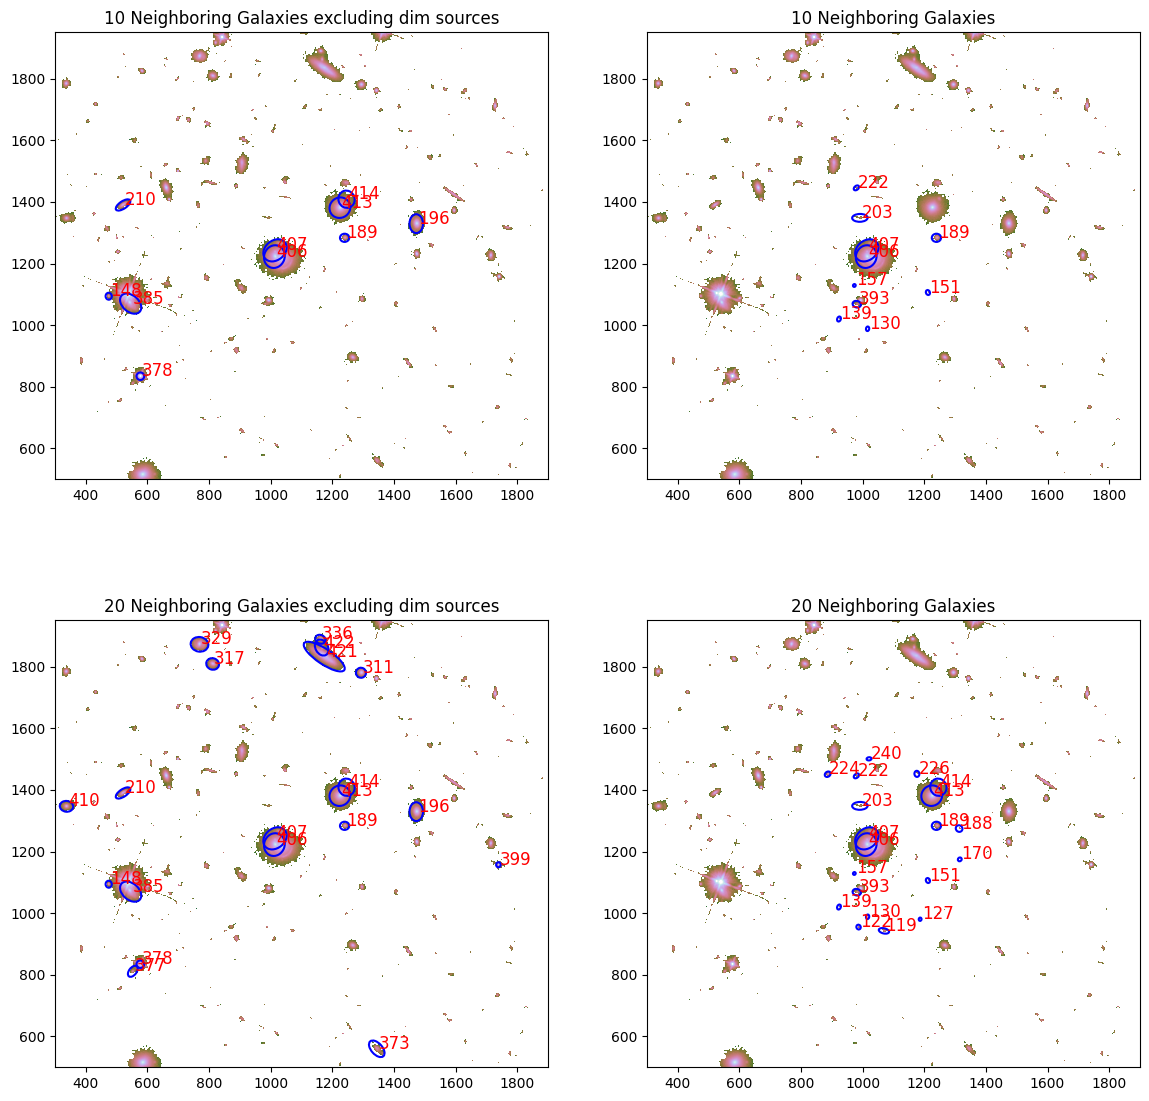

In [19]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighboring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighboring Galaxies")
axs[1, 0].set_title("20 Neighboring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighboring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

## Store the results to the YAML file

In [20]:
src_path = r"/kaggle/input/point-estimates/DESIJ0136-0008_point_estimates.yml"
dst_path = r"/kaggle/working/"
shutil.copy(src_path, dst_path)

# Existing YAML file with other parameters
existing_yaml_file = "DESIJ0136-0008_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10a_flux_selected": Sigma_10_1A,
    "Sigma_20a_flux_selected": Sigma_20_1A,
    "Sigma_10a": Sigma_10_allA,
    "Sigma_20a": Sigma_20_allA,
    "Sigma_10b_flux_selected": Sigma_10_1B,
    "Sigma_20b_flux_selected": Sigma_20_1B,
    "Sigma_10b": Sigma_10_allB,
    "Sigma_20b": Sigma_20_allB,
    "Sigma_10c_flux_selected": Sigma_10_1C,
    "Sigma_20c_flux_selected": Sigma_20_1C,
    "Sigma_10c": Sigma_10_allC,
    "Sigma_20c": Sigma_20_allC,
    "Sigma_10d_flux_selected": Sigma_10_1D,
    "Sigma_20d_flux_selected": Sigma_20_1D,
    "Sigma_10d": Sigma_10_allD,
    "Sigma_20d": Sigma_20_allD,
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [21]:
with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 32
{'R_eff_light': 0.975319454358417, 'Sigma_10a': 381.76481561908224, 'Sigma_10a_flux_selected': 59.35900562639013, 'Sigma_10b': 2150.733596521855, 'Sigma_10b_flux_selected': 436.5448068628626, 'Sigma_10c': 13634.102563671573, 'Sigma_10c_flux_selected': 12547.938713355832, 'Sigma_10d': 2160.123292969178, 'Sigma_10d_flux_selected': 3652.615935684964, 'Sigma_20a': 522.70321981249, 'Sigma_20a_flux_selected': 80.46873049778189, 'Sigma_20b': 2893.693698133874, 'Sigma_20b_flux_selected': 497.6213361180123, 'Sigma_20c': 12148.37376275045, 'Sigma_20c_flux_selected': 10803.720196593766, 'Sigma_20d': 2744.410748677198, 'Sigma_20d_flux_selected': 3538.9043996170394, 'center_x_light': [-0.6486278876896938, 0.0005665067555923331, 0.0005460389063404181], 'center_x_mass': [-0.44556860710808965, 0.005021353663892392, 0.0053271558634647165], 'center_y_light': [0.13945726180743695, 0.0005371810726526316, 0.0004427233955686116], 'center_y_mass': [1.3828699011926835, 0.010300

## Determining the mean for normalizing

In [22]:
# Mean of Fluxes
flux_10_mean = np.mean(df_all_20["Flux"][0:10])
flux_20_mean = np.mean(df_all_20["Flux"][0:20])
flux_10_1_mean = np.mean(df_1_20["Flux"][0:10])
flux_20_1_mean = np.mean(df_1_20["Flux"][0:20])

# Mean of Flux/Distance
flux_d_10_mean = np.mean(flux_d_10_all)
flux_d_20_mean = np.mean(flux_d_20_all)
flux_d_10_1_mean = np.mean(flux_d_10_1)
flux_d_20_1_mean = np.mean(flux_d_20_1)

print(flux_10_mean, flux_20_mean, flux_10_1_mean, flux_20_1_mean)
print(flux_d_10_mean, flux_d_20_mean, flux_d_10_1_mean, flux_d_20_1_mean)

400.39609435296734 363.1500933917465 1572.9019452664213 1097.6880220887697
6037.518923997962 4679.529931817905 13160.63464787665 7806.36337075311


In [23]:
mean_variables = {
    "Flux_10b_mean": flux_10_mean,
    "Flux_20b_mean": flux_20_mean,
    "Flux_selected_10b_mean": flux_10_1_mean,
    "Flux_selected_20b_mean": flux_20_1_mean,
    "Flux_dis_10_mean": flux_d_10_mean,
    "Flux_dis_20_mean": flux_d_20_mean,
    "Flux_dis_10_1_mean": flux_d_10_1_mean,
    "Flux_dis_20_1_mean": flux_d_20_1_mean,
}

# make all the numpy variales to float
mean_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in mean_variables.items()
}

In [24]:
# Write the dictionary to a YAML file
yaml_file_name = "DESIJ0136-0008_means.yml"
with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(mean_variables, yaml_file, default_flow_style=False)
print(f"YAML file '{yaml_file_name}' created successfully.")

YAML file 'DESIJ0136-0008_means.yml' created successfully.
